Loaded player: Hugo Bueno
Example: Progressive Passes -> 2.79 19.0
Hugo Bueno
Phase profile:
  1st Phase    :  28.6p
  2nd Phase    :  61.8p
  3rd Phase    :  84.4p
  Role in Possession:  55.2p

Summary scores:
  All-phase floor : 28.6p
  All-phase avg   : 58.3p
  Hero-ball score : 66.9


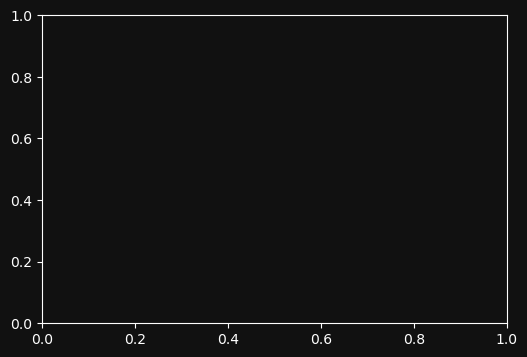

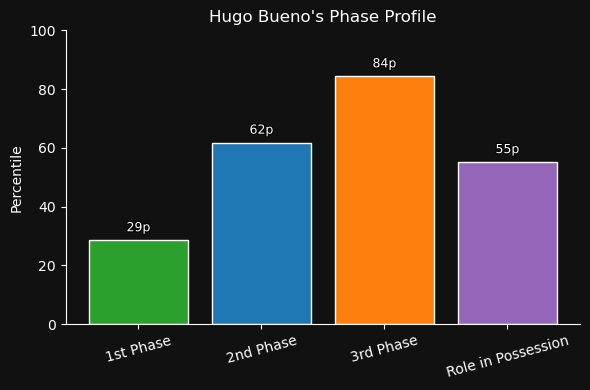

<Figure size 640x480 with 0 Axes>

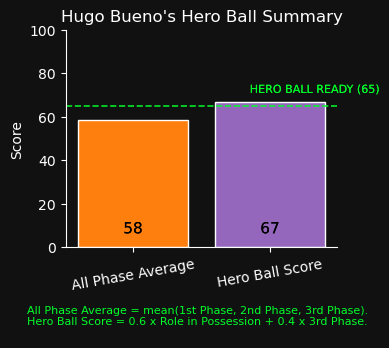

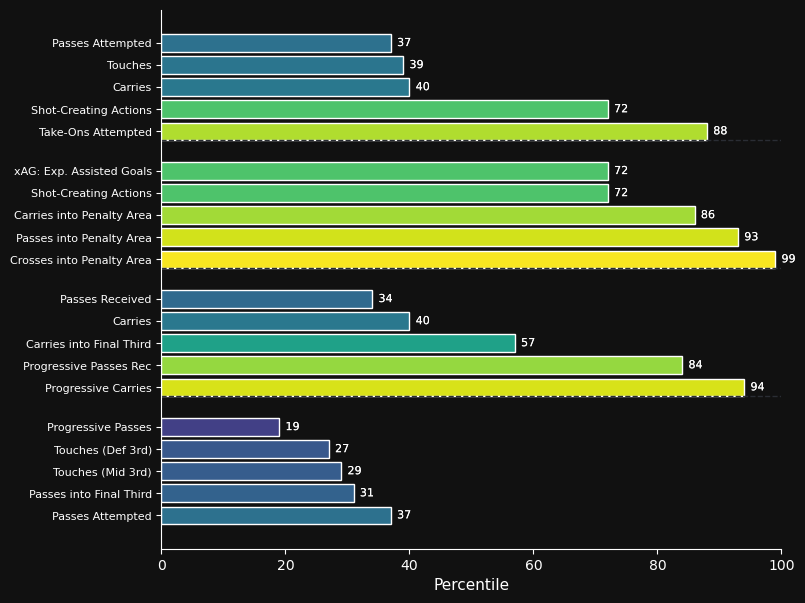

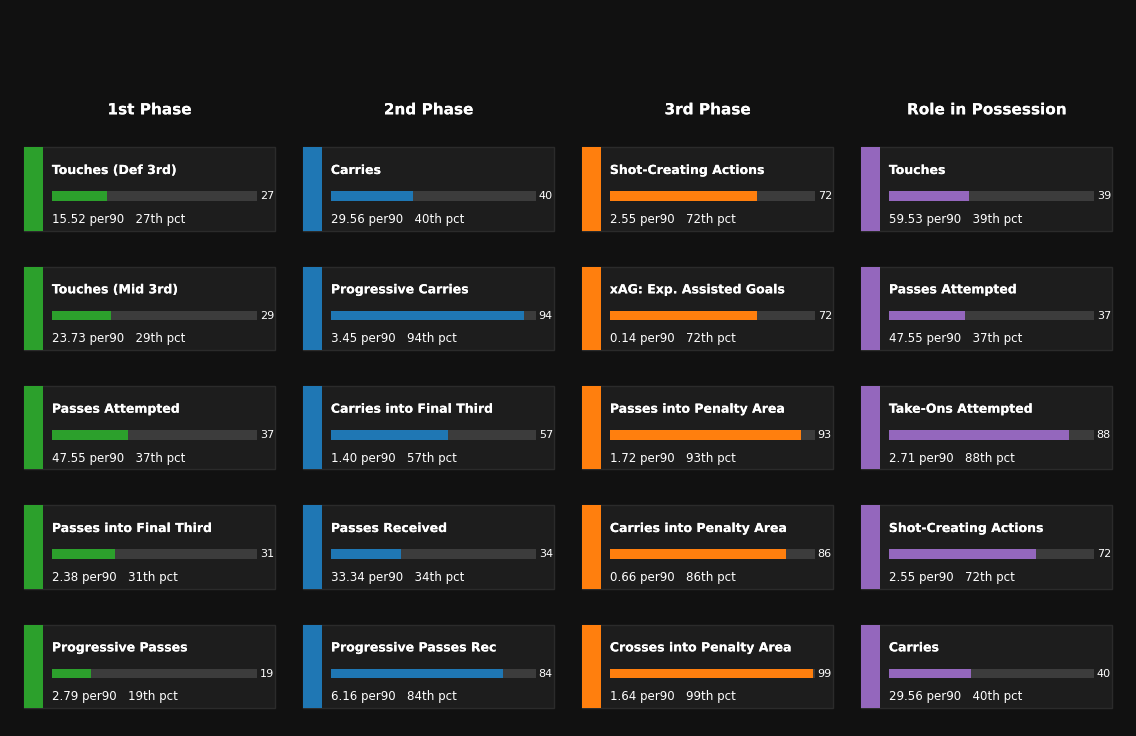

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects

FIG_BG = AX_BG = "#111111"
SHOW_FIGS = True

TILE_BG   = "#1d1d1d"
TILE_EDGE = "#2b2b2b"

DEF_COLOR    = "#d62728"
PROG_COLOR   = "#1f77b4"
AERIAL_COLOR = "#ff7f0e"
PASS_COLOR   = "#2ca02c"

def stroke_txt(txt=None, lw=1.5):
    return [
        path_effects.Stroke(linewidth=lw, foreground="black"),
        path_effects.Normal()
    ]

def clean_axis(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)

mpl.rcParams.update({
    "figure.facecolor": FIG_BG,
    "axes.facecolor": AX_BG,
    "savefig.facecolor": FIG_BG,
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
})


import pandas as pd

WORKBOOK = "cs4.xlsx"
PLAYER_SHEET = "Hugo Bueno"

raw = pd.read_excel(WORKBOOK, sheet_name=PLAYER_SHEET, header=0)

raw = raw.rename(columns={"Statistic": "Stat", "Per 90": "Per90"})
raw = raw.dropna(subset=["Stat"])

per90 = {}
pct   = {}

for _, r in raw.iterrows():
    stat = str(r["Stat"]).strip()
    if not stat or stat.lower() == "nan":
        continue

    try:
        per90[stat] = float(r["Per90"])
    except Exception:
        pass

    try:
        pct[stat] = float(r["Percentile"])
    except Exception:
        pass

player_name = PLAYER_SHEET
print("Loaded player:", player_name)
print("Example:", "Progressive Passes ->", per90.get("Progressive Passes"), pct.get("Progressive Passes"))


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from math import ceil

def get_pct(name, default=np.nan):
    v = pct.get(name, default)
    try:
        return float(v)
    except Exception:
        return default

def mean_pct(keys):
    vals = [get_pct(k) for k in keys]
    vals = [v for v in vals if not pd.isna(v)]
    return float(np.mean(vals)) if vals else np.nan

def safe_pct(name, pct_dict):
    v = pct_dict.get(name, np.nan)
    return np.nan if pd.isna(v) else float(v)

def safe_per90(name, per90_dict):
    v = per90_dict.get(name, np.nan)
    return np.nan if pd.isna(v) else float(v)


FIRST_PHASE_KEYS = [
    "Touches (Def 3rd)",
    "Touches (Mid 3rd)",
    "Passes Attempted",
    "Passes into Final Third",
    "Progressive Passes",
]

SECOND_PHASE_KEYS = [
    "Carries",
    "Progressive Carries",
    "Carries into Final Third",
    "Passes Received",
    "Progressive Passes Rec",
]

THIRD_PHASE_KEYS = [
    "Shot-Creating Actions",
    # "xG: Expected Goals",
    "xAG: Exp. Assisted Goals",
    "Passes into Penalty Area",
    "Carries into Penalty Area",
    "Crosses into Penalty Area",
]

ONBALL_KEYS = [
    "Touches",
    "Passes Attempted",
    "Take-Ons Attempted",
    "Shot-Creating Actions",
    "Carries",
]

PHASE_GROUPS = OrderedDict([
    ("1st Phase",     FIRST_PHASE_KEYS),
    ("2nd Phase",     SECOND_PHASE_KEYS),
    ("3rd Phase",     THIRD_PHASE_KEYS),
    ("Role in Possession",  ONBALL_KEYS),
])

def build_phase_profile(pct_dict):

    profile = {}
    for phase, metrics in PHASE_GROUPS.items():
        profile[phase] = mean_pct(metrics)
    return profile

def compute_all_phase_and_hero_ball(profile):

    core_phases = ["1st Phase", "2nd Phase", "3rd Phase"]
    core_vals = [profile[p] for p in core_phases if not pd.isna(profile[p])]

    all_phase_floor = min(core_vals) if core_vals else np.nan
    all_phase_avg   = float(np.mean(core_vals)) if core_vals else np.nan

    hub = profile.get("Role in Possession", np.nan)
    third = profile.get("3rd Phase", np.nan)
    if pd.isna(hub) or pd.isna(third):
        hero_ball_score = np.nan
    else:
        hero_ball_score = 0.6 * hub + 0.4 * third

    return all_phase_floor, all_phase_avg, hero_ball_score

phase_profile = build_phase_profile(pct)
all_phase_floor, all_phase_avg, hero_ball_score = compute_all_phase_and_hero_ball(phase_profile)

print(player_name)
print("Phase profile:")
for k, v in phase_profile.items():
    print(f"  {k:13s}: {v:5.1f}p")

print("\nSummary scores:")
print(f"  All-phase floor : {all_phase_floor:.1f}p")
print(f"  All-phase avg   : {all_phase_avg:.1f}p")
print(f"  Hero-ball score : {hero_ball_score:.1f}")

labels = list(phase_profile.keys())
values = [phase_profile[l] for l in labels]

fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_facecolor(FIG_BG)
ax.set_facecolor(AX_BG)

labels = list(phase_profile.keys())
values = [phase_profile[l] for l in labels]

# phase-specific colours
PHASE_COLORS = {
    "1st Phase":          PASS_COLOR,
    "2nd Phase":          PROG_COLOR,
    "3rd Phase":          AERIAL_COLOR,
    "Role in Possession": "#9467bd",
}

bar_colors = [PHASE_COLORS.get(lbl, PROG_COLOR) for lbl in labels]

fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_facecolor(FIG_BG)
ax.set_facecolor(AX_BG)

ax.bar(labels, values, color=bar_colors, edgecolor="white")

for x, v in zip(labels, values):
    if not pd.isna(v):
        ax.text(
            x, v + 2, f"{v:.0f}p",
            ha="center", va="bottom",
            fontsize=9,
            path_effects=stroke_txt("x")
        )

ax.set_ylim(0, 100)
ax.set_ylabel("Percentile")
ax.set_title(f"{player_name}'s Phase Profile")
ax.tick_params(axis="x", rotation=15)
clean_axis(ax)
plt.tight_layout()
if SHOW_FIGS: plt.show()

for x, v in zip(labels, values):
    if not pd.isna(v):
        ax.text(x, v + 2, f"{v:.0f}p", ha="center", va="bottom",
                fontsize=9, path_effects=stroke_txt("x"))

ax.set_ylim(0, 100)
ax.set_ylabel("Percentile")
ax.set_title(f"{player_name}'s Phase Profile")
ax.tick_params(axis="x", rotation=15)
clean_axis(ax)
plt.tight_layout()
if SHOW_FIGS: plt.show()

# score_labels = ["All Phase Floor", "All Phase Average", "Hero Ball Score"]
score_labels = ["All Phase Average", "Hero Ball Score"]

# score_values = [all_phase_floor, all_phase_avg, hero_ball_score]
score_values = [all_phase_avg, hero_ball_score]


HERO_BALL_POSSIBLE = 55
HERO_BALL_READY    = 65

fig, ax = plt.subplots(figsize=(3.5, 3.2))
fig.patch.set_facecolor(FIG_BG)
ax.set_facecolor(AX_BG)

bar_colors = []
for label, val in zip(score_labels, score_values):
    if label == "Hero Ball Score" and not pd.isna(val) and val >= HERO_BALL_READY:
        bar_colors.append("#9467bd")
    else:
        bar_colors.append(AERIAL_COLOR)

bars = ax.bar(score_labels, score_values, color=bar_colors, edgecolor="white")

y_min, y_max = 0, 100
ax.set_ylim(y_min, y_max)

text_y = y_min + 0.05 * (y_max - y_min)

def stroke_txt(txt, lw=0):
    return [path_effects.Stroke(linewidth=lw, foreground="black"),
            path_effects.Normal()]

for x, v in zip(score_labels, score_values):
    if not pd.isna(v):
        ax.text(
            x, text_y,
            f"{v:.0f}",
            ha="center", va="bottom",
            fontsize=11,
            color="#000000",
            path_effects=stroke_txt("x")
        )

# ax.axhline(HERO_BALL_POSSIBLE, color="#888888", lw=1.0, ls="--", alpha=0.8)
ax.axhline(HERO_BALL_READY,    color="#00ff2a",   lw=1.2, ls="--", alpha=0.9)

x_pos = len(score_labels) - 0.2
# ax.text(x_pos, HERO_BALL_POSSIBLE + 1, "HERO BALL POSSIBLE (55)",
#         fontsize=8, color="#bbbbbb", ha="right", va="bottom",
#         path_effects=stroke_txt("x"))
ax.text(x_pos, HERO_BALL_READY + 5, "HERO BALL READY (65)",
        fontsize=8, color="#00ff2a", ha="right", va="bottom",
        path_effects=stroke_txt("x"))

ax.set_ylabel("Score")
ax.set_title(f"{player_name}'s Hero Ball Summary")
ax.tick_params(axis="x", rotation=10)
clean_axis(ax)

footnote = (
    # "All Phase Floor = min(1st Phase, 2nd Phase, 3rd Phase).\n"
    "All Phase Average = mean(1st Phase, 2nd Phase, 3rd Phase).\n"
    "Hero Ball Score = 0.6 x Role in Possession + 0.4 x 3rd Phase.\n"
)

plt.subplots_adjust(bottom=0.20)

fig.text(
    0.5, 0.02, footnote,
    ha="center", va="top",
    fontsize=8, color="#00ff2a",
    linespacing=1.2
)

if SHOW_FIGS: plt.show()

heat_rows = []
for group, stats_list in PHASE_GROUPS.items():
    for stat in stats_list:
        v = pct.get(stat, np.nan)
        if pd.isna(v):
            continue
        heat_rows.append((group, stat, float(v)))

df_heat = pd.DataFrame(heat_rows, columns=["Group", "Stat", "Percentile"])

if df_heat.empty:
    print("No data for phase heatmap.")
else:
    df_heat = df_heat.sort_values(["Group", "Percentile"], ascending=[True, False])

    y_labels = []
    y_positions = []
    ypos = 0
    group_separators = []
    last_group = None

    for _, row in df_heat.iterrows():
        if row["Group"] != last_group:
            if last_group is not None:
                ypos += 0.8
                group_separators.append(ypos)
            last_group = row["Group"]
        y_labels.append(f"{row['Stat']}")
        y_positions.append(ypos)
        ypos += 1.0

    fig, ax = plt.subplots(figsize=(8, max(4, len(y_positions)*0.35)))
    fig.patch.set_facecolor(FIG_BG)
    ax.set_facecolor(AX_BG)

    norm = mpl.colors.Normalize(vmin=0, vmax=100)
    cmap = mpl.colormaps.get_cmap("viridis")

    for (y, (_, row)) in zip(y_positions, df_heat.iterrows()):
        c = cmap(norm(row["Percentile"]))
        ax.barh(
            [y], [row["Percentile"]],
            color=c, edgecolor="white", height=0.8
        )
        ax.text(
            row["Percentile"] + 1, y,
            f"{row['Percentile']:.0f}",
            va="center", ha="left", fontsize=8,
            path_effects=stroke_txt("x")
        )

    for sep in group_separators:
        ax.axhline(sep - 0.4, color="#2a2d34", lw=1.0, ls="--")

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontsize=8)
    ax.set_xlim(0, 100)
    ax.set_xlabel("Percentile", fontsize=11)

    clean_axis(ax)
    if SHOW_FIGS: plt.show()


tile_groups = PHASE_GROUPS

group_color = {
    "1st Phase":     PASS_COLOR,
    "2nd Phase":     PROG_COLOR,
    "3rd Phase":     AERIAL_COLOR,
    "Role in Possession":  "#9467bd",
}

group_tiles = {}
for group, metrics in tile_groups.items():
    mt = []
    for m in metrics:
        p = safe_pct(m, pct)
        if not pd.isna(p):
            mt.append(m)
    if mt:
        group_tiles[group] = mt

if group_tiles:
    groups = list(group_tiles.keys())
    n_cols = len(groups)
    max_rows = max(len(ms) for ms in group_tiles.values())
    n_rows = max_rows

    fig, ax = plt.subplots(figsize=(3.6 * n_cols, 1.7 * n_rows + 0.8))
    fig.patch.set_facecolor(FIG_BG)
    ax.set_facecolor(AX_BG)

    ax.set_xlim(0, n_cols)
    ax.set_ylim(0, n_rows + 1)
    ax.invert_yaxis()
    ax.axis("off")

    for col_idx, group in enumerate(groups):
        x_center = col_idx + 0.5
        y_header = 0.9
        ax.text(
            x_center, y_header,
            group,
            fontsize=11, fontweight="bold", color="white",
            ha="center", va="bottom", zorder=5,
            path_effects=stroke_txt("x")
        )

    for col_idx, group in enumerate(groups):
        metrics = group_tiles[group]
        group_col = group_color.get(group, "white")

        for row_idx, metric in enumerate(metrics):
            y_row = row_idx + 1

            x0 = col_idx + 0.05
            y0 = y_row + 0.15
            w  = 0.9
            h  = 0.7

            tile_rect = Rectangle(
                (x0, y0), w, h,
                facecolor=TILE_BG, edgecolor=TILE_EDGE, linewidth=1.0,
                zorder=1
            )
            ax.add_patch(tile_rect)

            accent_w = 0.07
            accent = Rectangle(
                (x0, y0), accent_w, h,
                facecolor=group_col, edgecolor="none", zorder=2
            )
            ax.add_patch(accent)

            title_x = x0 + accent_w + 0.03
            title_y = y0 + 0.25

            t1 = ax.text(
                title_x, title_y,
                metric,
                fontsize=9, fontweight="bold", color="white",
                va="bottom", ha="left", zorder=3
            )
            t1.set_path_effects(stroke_txt("x"))

            p90    = safe_per90(metric, per90)
            pctile = safe_pct(metric, pct)

            num_str = ""
            if not pd.isna(p90):
                num_str += f"{p90:.2f} per90   "
            if not pd.isna(pctile):
                num_str += f"{pctile:.0f}th pct"

            ax.text(
                title_x, y0 + h - 0.15,
                num_str,
                fontsize=8.5, color="white",
                va="top", ha="left", zorder=3
            )

            bar_margin_x = title_x
            bar_margin_y = y0 + h - 0.33
            bar_w = w - (bar_margin_x - x0) - 0.065
            bar_h = 0.08

            ax.add_patch(Rectangle(
                (bar_margin_x, bar_margin_y),
                bar_w, bar_h,
                facecolor="#3c3c3c",
                edgecolor="none",
                zorder=2
            ))

            if not pd.isna(pctile):
                frac = np.clip(pctile / 100.0, 0.0, 1.0)
                ax.add_patch(Rectangle(
                    (bar_margin_x, bar_margin_y),
                    bar_w * frac, bar_h,
                    facecolor=group_col,
                    edgecolor="none",
                    zorder=3
                ))
                ax.text(
                    bar_margin_x + bar_w + 0.01, bar_margin_y + bar_h / 2,
                    f"{pctile:.0f}",
                    fontsize=8, color="white",
                    va="center", ha="left", zorder=4
                )

    if SHOW_FIGS: plt.show()
    else: plt.close(fig)

